### combination of best predictors for each mean temperature and uncertainty 

In [1]:
import os
import numpy as np
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
import matplotlib
import time

In [2]:
plt.rcParams.update({
    "text.usetex": True
})

For each spread, three different categories in one plot 

In [3]:
### headers for different groups of features

header = ["Temperature", "Metallicity Altitude",
          "Mean Degree", "Average clustering coefficient",
          "Average node betweenness centrality", "Edge betweenness centrality",
          "Average shortest path length", "Average neighbor degree",
          "CO abundance", "CH4 abundance", "NH3 abundance",	"H2O abundance",
          "Delta G distribution",	"Phi distribution"
          "Mean of Temperature Distribution", "Kzz", "Spread of Uncertainty"]

header_abundance = ["CO abundance", "CH4 abundance", "NH3 abundance",	"H2O abundance"]

header_topology = ["Mean Degree", "Average clustering coefficient",
                "Average node betweenness centrality", "Edge betweenness centrality",
                "Average shortest path length", "Average neighbor degree"]


# compute accuracy of predicting Kzz using different combination of G, topoAve, and abundance.
dict_var = {
            #individual group
            'g':['Delta G distribution'],  'topo': header_topology, 'ab': header_abundance,
            #group combination
            'topo_ab': header_topology + header_abundance,
            'g_topo': ['Delta G distribution'] + header_topology,
            'g_ab' : ['Delta G distribution'] + header_abundance,
            #three group
            'g_topo_ab': ['Delta G distribution'] + header_topology + header_abundance,
            #individual topology
            'degree': ["Mean Degree"], 'cc': ["Average clustering coefficient"],
            'spl': ["Average shortest path length"],  'neighbor': ["Average neighbor degree"],
            'betw': ["Average node betweenness centrality"], 'edgebetw': ["Edge betweenness centrality"],
            #g + individual topology
            'g_degree': ['Delta G distribution'] + ["Mean Degree"],
            'g_cc': ['Delta G distribution'] + ["Average clustering coefficient"],
            'g_spl': ['Delta G distribution'] + ["Average shortest path length"],
            'g_neighbor': ['Delta G distribution'] + ["Average neighbor degree"],
            'g_betw': ['Delta G distribution'] + ["Average node betweenness centrality"],
            'g_edgebetw': ['Delta G distribution'] + ["Edge betweenness centrality"],
            # individual abundance
            'CO': ["CO abundance"], 'CH4': ["CH4 abundance"], 'NH3': ["NH3 abundance"], 'H2O': ["H2O abundance"],
            # c
            'g_CO': ['Delta G distribution'] + ["CO abundance"],
            'g_CH4': ['Delta G distribution'] + ["CH4 abundance"],
            'g_NH3': ['Delta G distribution'] + ["NH3 abundance"],
            'g_H2O': ['Delta G distribution'] + ["H2O abundance"],
            'CO_NH3': ["CO abundance"] + ["NH3 abundance"],
            'spl_neighbor_betw_edgebetw': ["Average shortest path length"] + ["Average neighbor degree"]
                                          + ["Average node betweenness centrality"] + ["Edge betweenness centrality"],
            'g_CO_NH3': ['Delta G distribution'] + ["CO abundance"] + ["NH3 abundance"],
            'g_spl_neighbor_betw_edgebetw': ['Delta G distribution'] + ["Average shortest path length"] + ["Average neighbor degree"]
                                          + ["Average node betweenness centrality"] + ["Edge betweenness centrality"],
            'top_predictor': ['Delta G distribution']  + ["CO abundance"] + ["NH3 abundance"]
                             + ["Average shortest path length"] + ["Average neighbor degree"]
                             + ["Average node betweenness centrality"] + ["Edge betweenness centrality"],

}


legend_label = {"g":"G", 
                "ab": r"$\mathrm{A}^*$", 
                "topo": r"$\mathrm{N}^*$", 
                "g_ab": "G + Abundance", 
                "g_topo": "G + Topology", 
                'topo_ab':"Topology + Abundance", 
                'g_topo_ab': "G + Topology + Abundance",
                'degree': r'$\langle k \rangle$', 
                'cc': r'$\langle C \rangle$',
                'spl': r'$\langle \ell \rangle$' , 
                'neighbor': r'$\langle k_{nn} \rangle$',
                'betw': r'$\langle g(v) \rangle$', 
                'edgebetw': r'$\langle g(e) \rangle$',
                'g_degree': "G + %s"%r'$\langle k \rangle$',
                'g_cc': "G + %s"%r'$\langle C \rangle$', 
                'g_spl': "G + %s"%r'$\langle \ell \rangle$', 
                'g_neighbor': "G + %s"%r'$\langle k_{nn} \rangle$', 
                'g_betw': "G + %s"%r'$\langle g(v) \rangle$', 
                'g_edgebetw': "G + %s"%r'$\langle g(e) \rangle$', 
                "CH4": r"$\mathrm{CH}_4$", 
                "CO": r"$\mathrm{CO}$", 
                "H2O": r"$\mathrm{H_2O}$", 
                "NH3": r"$\mathrm{NH}_3$",
                'g_CO': "G + %s"%r"$\mathrm{CO}$", 
                'g_CH4': "G + %s"%r"$\mathrm{CH}_4$",
                'g_NH3': "G + %s"%r"$\mathrm{NH}_3$",
                'g_H2O': "G + %s"%r"$\mathrm{H_2O}$",
                'top': r"$\mathrm{T}^*$"            
                }

individual_group = ['g', 'topo', 'ab']
group_combination = ['topo_ab', 'g_topo', 'g_ab']
three_group = ['g_topo_ab']
simple_topo = ['degree', 'cc']
complex_topo = ['spl', 'neighbor']
betweenness = ['betw', 'edgebetw']
g_individual_topology = ['g_degree','g_cc', 'g_spl', 'g_neighbor', 'g_betw', 'g_edgebetw']
individual_abundance = ["CH4", "CO", "H2O", "NH3"]
g_individual_abundance = ['g_CO', 'g_CH4','g_NH3','g_H2O']
individual_topology = simple_topo + complex_topo + betweenness
individual_features = ['g'] + individual_abundance + individual_topology


In [4]:
data_dir = "/Users/hkim78/work/HotJupiter/ML/results/accuracy/2021/"

### to transfer the results of ML for individual variables (features) 
### as function of temperature to a dict {temp: {feature: predicting accuracy}}
list_temp = np.arange(400, 2100, 100)

selected = 3 #nth highest accuracy

dict_temp_feature = dict()
for spread in ["50", "250", "500"]:

    dict_temp_feature[spread] = dict()
    for temp_index in range(len(list_temp)):
        dict_temp_feature[spread][temp_index] = dict()

    for feature_group in individual_features:      
        input_path = data_dir + "accuracy_%s.json"%feature_group
        with open(input_path) as infile:
            a = json.load(infile)
        for temp_index in range(len(list_temp)):
            dict_temp_feature[spread][temp_index][feature_group] = a[spread][temp_index]      

In [5]:
### to identify n (=selected) features with highest value
best_features = dict()

for spread in ["50", "250", "500"]:
    best_features[spread] = dict()

    for temp_index in range(len(list_temp)):
        sorted_list = sorted(dict_temp_feature[spread][temp_index].values())
        selected_value = sorted_list[-selected]

        best_features[spread][temp_index] = list()
        for x in dict_temp_feature[spread][temp_index].keys():
            if dict_temp_feature[spread][temp_index][x] < selected_value:
                continue
            best_features[spread][temp_index].append(x)

In [6]:
### to load the results ML for the set of best predictors 
### as function of temperature to a dict {temp:predicting accuracy}}

input_path = data_dir + "accuracy_bestPredictors.json"
with open(input_path) as infile:
    best_accuary = json.load(infile) 
    

In [7]:
### to load the results ML for the set of abundance variables  
### as function of temperature to a dict {temp:predicting accuracy}}

input_path = data_dir + "accuracy_ab.json"
with open(input_path) as infile:
    ab_accuary = json.load(infile) 

In [8]:
### to load the results ML for the set of abundance variables  
### as function of temperature to a dict {temp:predicting accuracy}}

input_path = data_dir + "accuracy_topo.json"
with open(input_path) as infile:
    topo_accuary = json.load(infile) 

In [9]:
# main figure
dir_plot = "/Users/hkim78/work/HotJupiter/plot/atmosphere-uncertainty/machine_learning/2021/"

### figure for top 3 individual predicting accuracy and combined one. 
for spread in ["50"]:    
    plt.figure(figsize=(9, 10))
    j = 1
    for temp_index in np.arange(1, len(list_temp)-1):   
        for feature_group in legend_label.keys(): 

            plt.subplot(5, 3, j)

            # load the 3 highest predictive variables and their predicting accuracy for each temperature  
            sorted_list = sorted(dict_temp_feature[spread][temp_index].values())
            selected_value = sorted_list[-selected]
            
            feature_label = list()
            clrs = list()
            accuracy_values = list()
            
            for x in dict_temp_feature[spread][temp_index].keys():
                # remove mean degree and cc
                if x == "degree" or x == "cc":
                    continue
                feature_label.append(legend_label[x])
                accuracy_values.append(dict_temp_feature[spread][temp_index][x])
                
                if x in best_features[spread][temp_index]:
                    clrs.append('indianred')
                else:
                    clrs.append('darkgrey')
                    
            # load the predicting accuracy of the set of the 3 highest variables 
            clrs.append('goldenrod')
            feature_label.append(legend_label['top'])
            accuracy_values.append(best_accuary[spread][temp_index])
            
            # load the predicting accuracy of the set of the abundance variables 
            clrs.append('cornflowerblue')
            feature_label.append(legend_label['ab'])
            accuracy_values.append(ab_accuary[spread][temp_index])
            
            # load the predicting accuracy of the set of the abundance variables 
            clrs.append('olivedrab')
            feature_label.append(legend_label['topo'])
            accuracy_values.append(topo_accuary[spread][temp_index])
            
            # bar plots 
            plt.bar(feature_label, accuracy_values, width=0.72, color=clrs)
            
            # axis configuration 
            plt.ylim([0.0,1.05])
            plt.xticks(fontsize = 11, rotation=90)
            plt.yticks(fontsize= 10)
            
            # subplot titles for the mean temperature 
            plt.title("%sK"%(list_temp[temp_index]))
            
            if j == 7: 
                plt.ylabel("Predicting Accuracy\n", fontsize = 14)
                
        j += 1

    plt.tight_layout()

    plt.savefig(dir_plot + "/png-files/barplot_accuracy_spread_%s_best_predictor_combination.png"%spread, dpi=300)
    plt.savefig(dir_plot + "/pdf-files/barplot_accuracy_spread_%s_best_predictor_combination.pdf"%spread)
    plt.show()

<ipython-input-10-1f639dc8a55f>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5, 3, j)
<ipython-input-10-1f639dc8a55f>:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(5, 3, j)


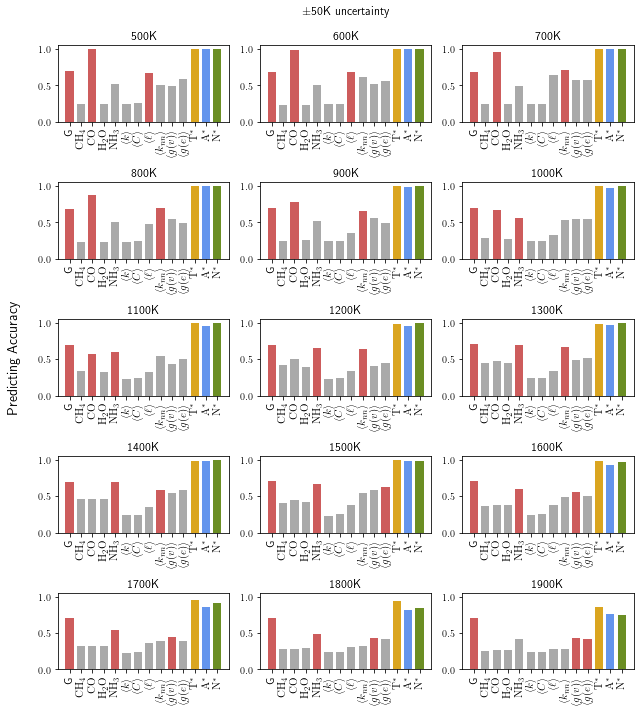

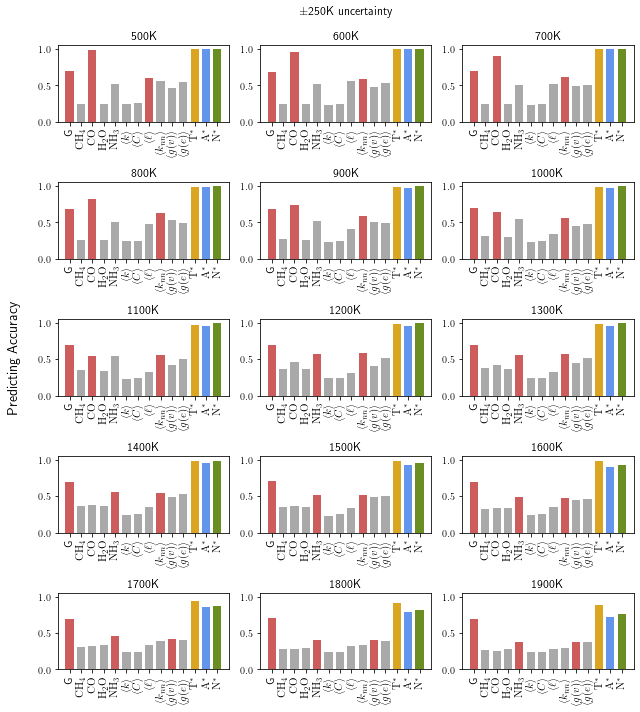

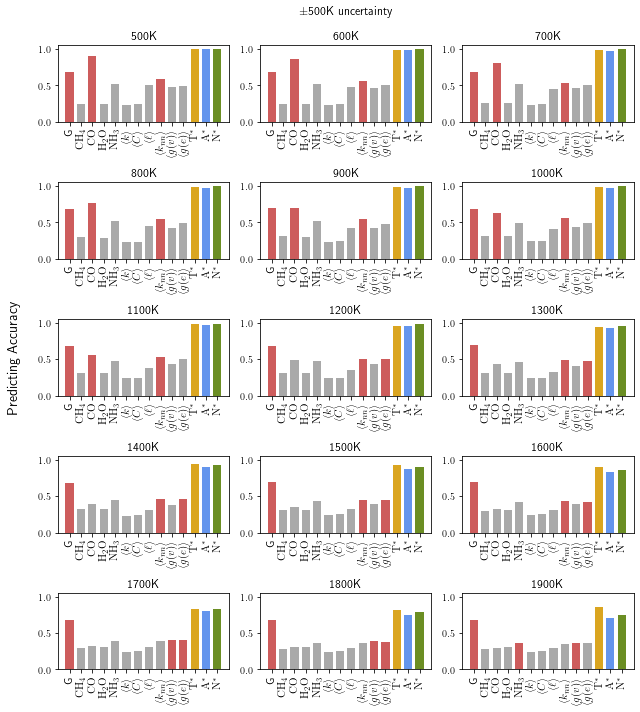

In [10]:
# supp figure
dir_plot = "/Users/hkim78/work/HotJupiter/plot/atmosphere-uncertainty/machine_learning/2021/"

### figure for top 3 individual predicting accuracy and combined one. 
for spread in ["50", "250", "500"]:    
    plt.figure(figsize=(9, 10))
    j = 1
    for temp_index in np.arange(1, len(list_temp)-1):   
        for feature_group in legend_label.keys(): 

            plt.subplot(5, 3, j)

            # load the 3 highest predictive variables and their predicting accuracy for each temperature  
            sorted_list = sorted(dict_temp_feature[spread][temp_index].values())
            selected_value = sorted_list[-selected]

            feature_label = list()
            clrs = list()
            accuracy_values = list()

            for x in dict_temp_feature[spread][temp_index].keys():
                feature_label.append(legend_label[x])
                accuracy_values.append(dict_temp_feature[spread][temp_index][x])

                if x in best_features[spread][temp_index]:
                    clrs.append('indianred')
                else:
                    clrs.append('darkgrey')

            # load the predicting accuracy of the set of the 3 highest variables 
            clrs.append('goldenrod')
            feature_label.append(legend_label['top'])
            accuracy_values.append(best_accuary[spread][temp_index])

            # load the predicting accuracy of the set of the abundance variables 
            clrs.append('cornflowerblue')
            feature_label.append(legend_label['ab'])
            accuracy_values.append(ab_accuary[spread][temp_index])

            # load the predicting accuracy of the set of the abundance variables 
            clrs.append('olivedrab')
            feature_label.append(legend_label['topo'])
            accuracy_values.append(topo_accuary[spread][temp_index])

            # bar plots 
            plt.bar(feature_label, accuracy_values, width=0.72, color=clrs)

            # axis configuration 
            plt.ylim([0.0,1.05])
            plt.xticks(fontsize = 11, rotation=90)
            plt.yticks(fontsize= 10)

            # subplot titles for the mean temperature
            if j == 2:
                plt.title(r"$\pm$%sK uncertainty"%spread + "\n\n%sK"%list_temp[temp_index])
            else:
                plt.title("%sK"%(list_temp[temp_index]))
            
            if j == 7: 
                plt.ylabel("Predicting Accuracy\n", fontsize = 14)

        j += 1

    plt.tight_layout()

    plt.savefig(dir_plot + "/png-files/supp_barplot_accuracy_spread_%s_best_predictor_combination.png"%spread, dpi=300)
    plt.savefig(dir_plot + "/pdf-files/supp_barplot_accuracy_spread_%s_best_predictor_combination.pdf"%spread)
    plt.show()